In [16]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [17]:
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.simplefilter('ignore', NoAuthWarning)
from socceraction.data.statsbomb import StatsBombLoader

api = StatsBombLoader(getter="remote", creds={"user": "", "passwd": ""})

In [18]:
import statsbombplot as pys
import socceraction.spadl as spadl
from tabulate import tabulate

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

def plot_buildup(goal_id, df_actions, c_string):
    df = df_actions[goal_id-5:goal_id+1].copy().reset_index(drop=True)

    opponent_df = df[df['team_name'] != df['team_name'].iloc[len(df)-1]]

    if opponent_df.empty:
        df = df[0:]
    else:
        last_row = opponent_df.index[-1]+1
        df = df[last_row:]

    df["nice_time"] = df.apply(nice_time, axis=1)
    
    print(c_string)
    print(tabulate(df[['nice_time', 'player_name', 'type_name', 'result_name', 'team_name']], headers = df.columns, showindex=False))

    ax = pys.draw_actions(
        df
    )

def find_goal(df, team_id):
    df = df[(df['type_id'] == 11) & (df['result_id'] == 1) & (df['team_id'] == team_id)]
    return df.index


No goals were scored by Sevilla in Sevilla vs Barcelona (La Liga Regular Season - 2019/2020)
No goals were scored by Sevilla in Sevilla vs Barcelona (La Liga Regular Season - 2014/2015)
No goals were scored by Tottenham Hotspur in Tottenham Hotspur vs Liverpool (Champions League Final - 2018/2019)
[Juventus] vs Real Madrid (Champions League Final - 2016/2017)
game_id    original_event_id        period_id    time_seconds    team_id
---------  -----------------------  -----------  --------------  ---------
26m17s     Alex Sandro Lobo Silva   dribble      success         Juventus
26m17s     Alex Sandro Lobo Silva   cross        success         Juventus
26m18s     Gonzalo Gerardo Higuaín  dribble      success         Juventus
26m19s     Gonzalo Gerardo Higuaín  pass         success         Juventus
26m20s     Mario Mandžukić          dribble      success         Juventus
26m20s     Mario Mandžukić          shot         success         Juventus


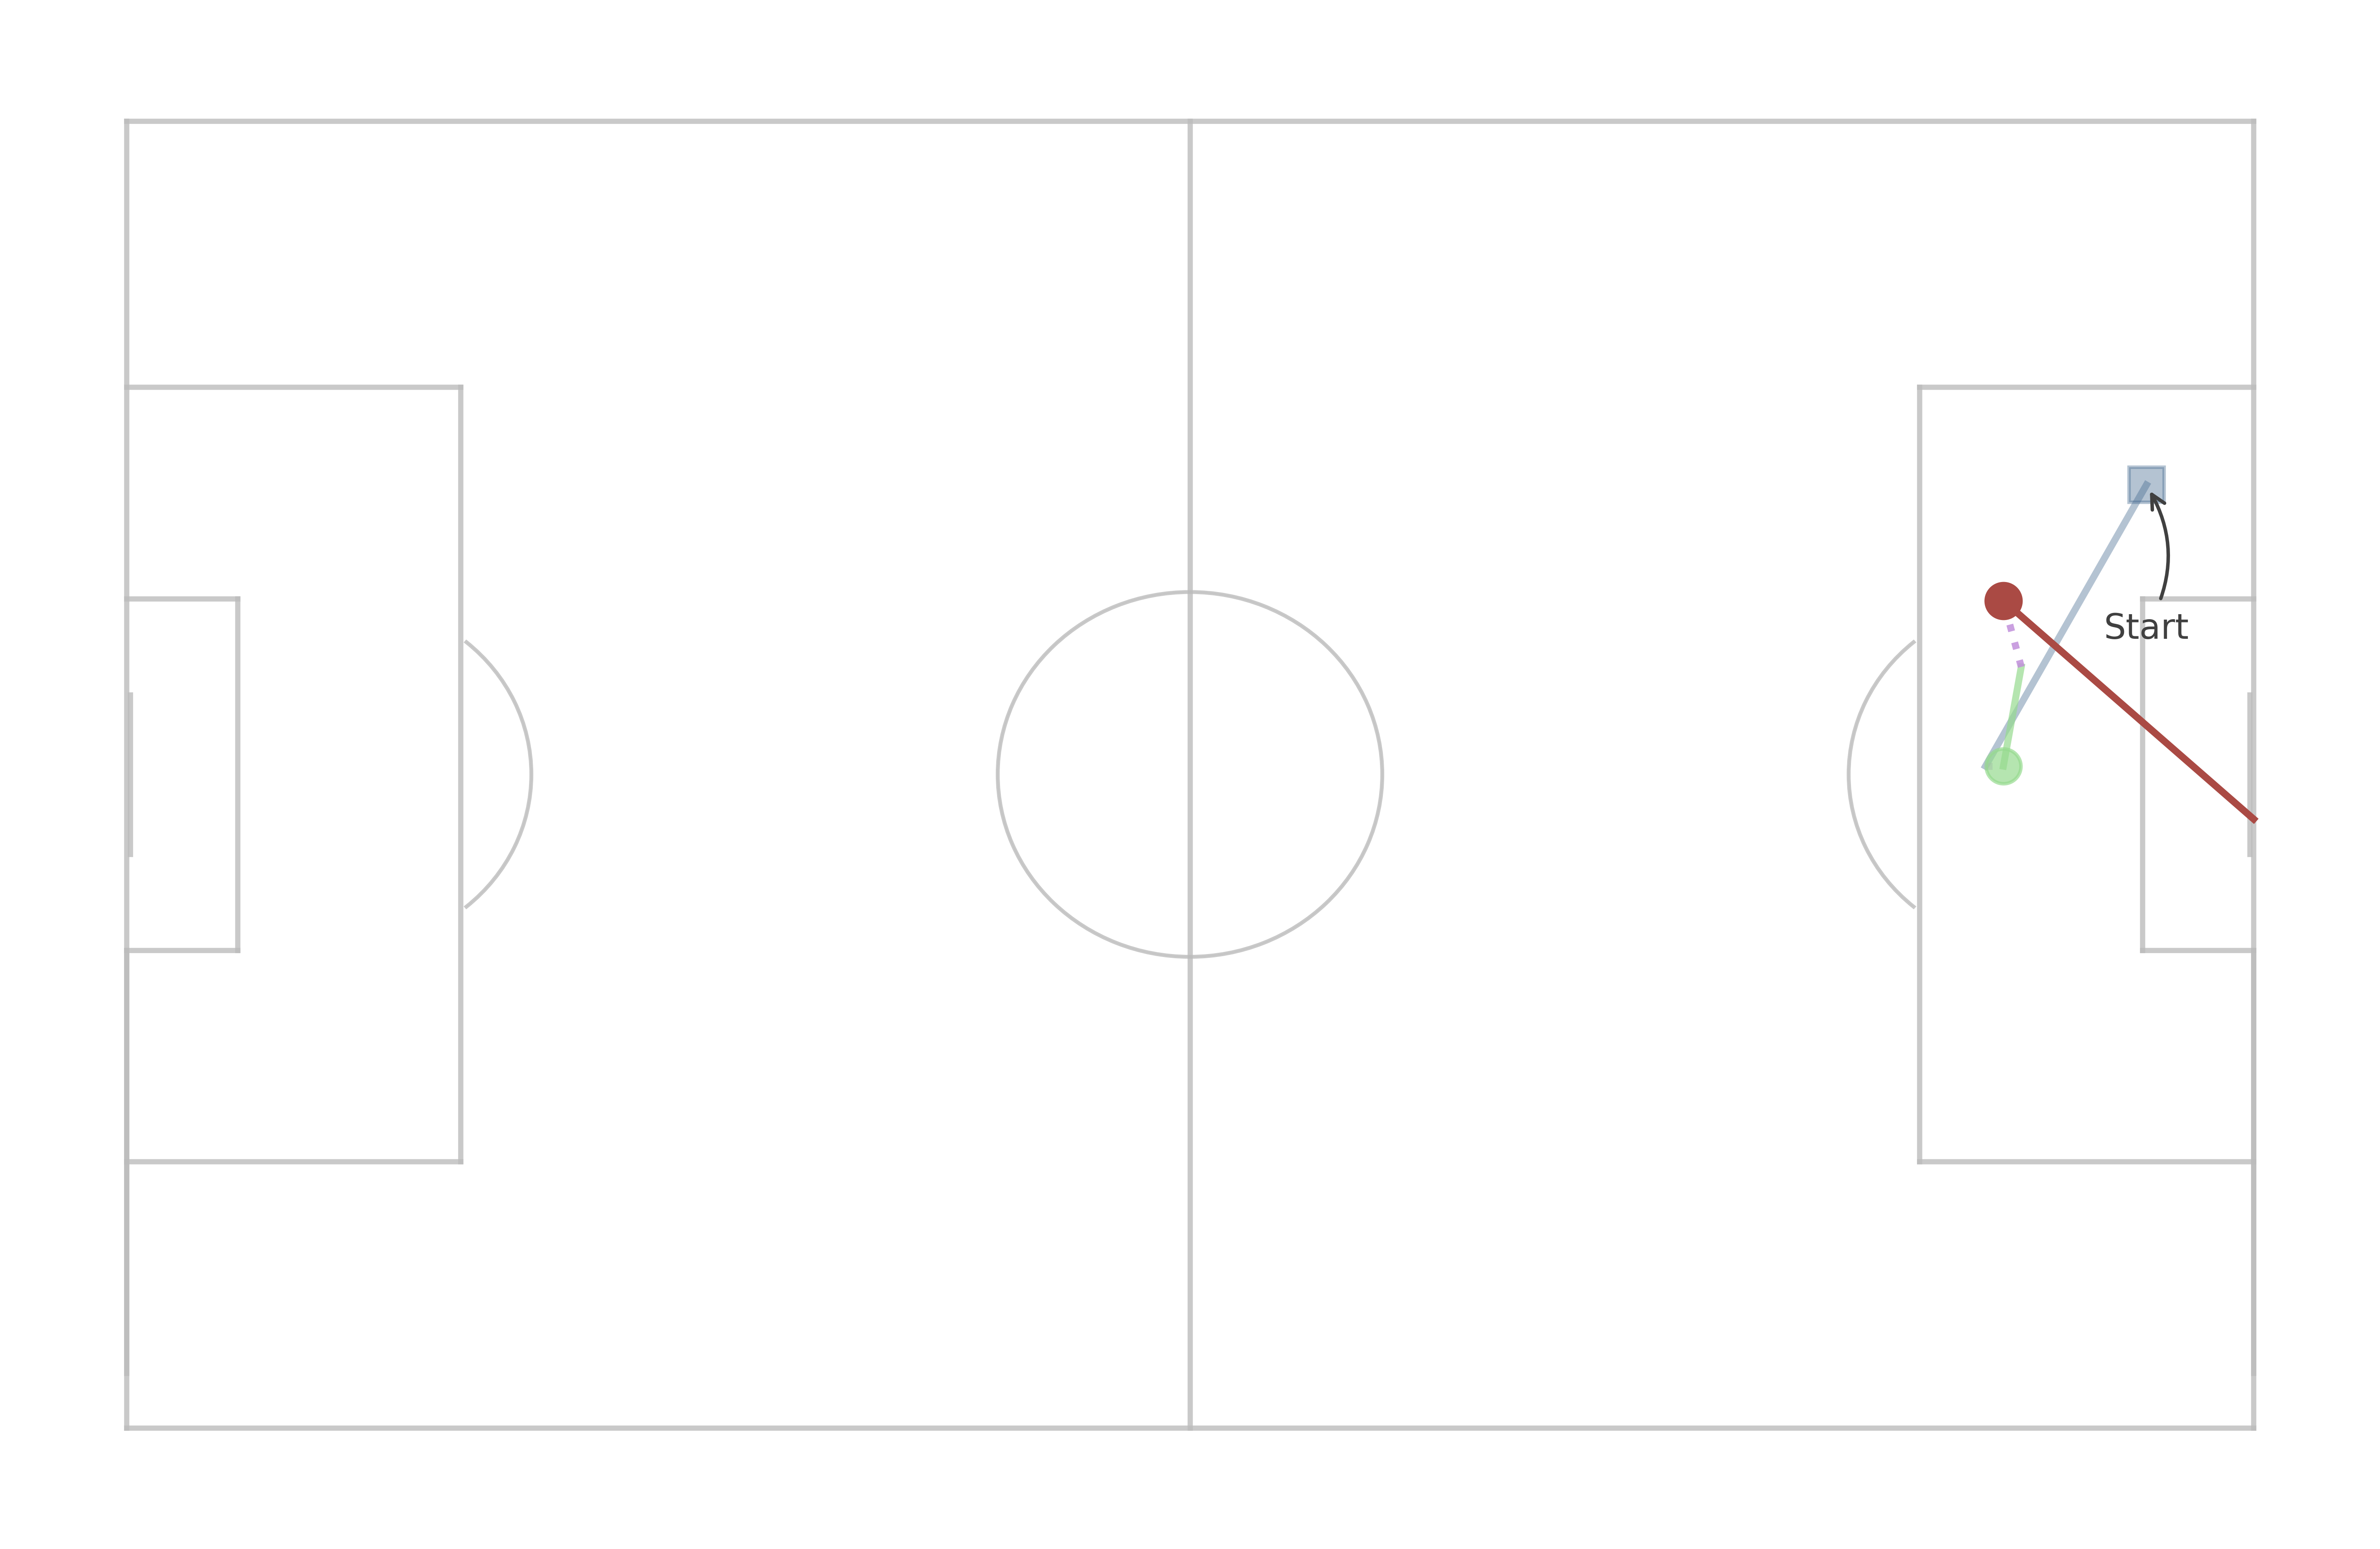

In [19]:
import random

loop = True

while loop:

    loop = False

    df_competitions = api.competitions()
    random_row = df_competitions.sample(1)

    competition_id = random_row['competition_id'].item()
    season_id = random_row['season_id'].item()
    competition_name = random_row['competition_name'].item()
    season_name = random_row['season_name'].item()

    df_games = api.games(competition_id=competition_id, season_id=season_id)
    
    all_teams = list(df_games['home_team_id'].unique())
    team_id = random.choice(all_teams)

    df_games = df_games[(df_games['away_team_id'] == team_id) | (df_games['home_team_id'] == team_id)]
    all_games = list(df_games['game_id'])
    g = random.choice(all_games)
    
    c_stage = df_games[df_games['game_id'] == g]['competition_stage'].item()
    df_teams = api.teams(game_id=g)
    df_players = api.players(game_id=g)
    df_events = api.events(game_id=g)
    team_name = df_events[df_events['team_id'] == team_id]['team_name'].iloc[0]
    teams = list(df_events['team_name'].unique())
    teams.remove(team_name)

    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=team_id)
    df_actions = (
    spadl
    .add_names(df_actions)
    .merge(api.teams(game_id=g))
    .merge(api.players(game_id=g))
    )
    df_actions = df_actions.sort_values(by=['period_id', 'time_seconds'], ascending=[True, True]).reset_index(drop=True)

    c_string = f"[{team_name}] vs {teams[0]} ({competition_name} {c_stage} - {season_name})"
    c_string_no_goal = f"{team_name} vs {teams[0]} ({competition_name} {c_stage} - {season_name})"

    goals = list(find_goal(df_actions, team_id))

    if goals:
        i = random.choice(goals)
        plot_buildup(i, df_actions, c_string)
    else:
        print(f"No goals were scored by {team_name} in {c_string_no_goal}")
        loop = True